In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [34]:
#import nltk
#from nltk.stem import PorterStemmer

#nltk.download('stopwords')
#ps = PorterStemmer()

def preprocess(line):
    # TODO remove <br> tags
    # TODO stemming for later parts
    # break into words?
    break_rgx = re.compile(r"<[a-z ]*/>")
    line = break_rgx.sub(" ", line)
    punctuation_rgx = re.compile(r"[^a-zA-Z ]")
    line = punctuation_rgx.sub("", line)
    words = re.split(r"\s+", line.lower())
#    ps.stem()
    return words


In [46]:
# model
class MultinomialEventModel:
    
    def __init__(self, n):
        self.n = n
        self.cond_params = [[] for i in range(n)]
        self.cond_params_denom = np.zeros(n)
        self.params = np.zeros(n)
        
        self.word_map = {}
        self.index_map = [] # will this be used?
        self.next_word_idx = 0

        # for wordcloud generation
        self.cond_param_freqs = [{} for i in range(n)]

    def fit(self, dataset):
        for (e,c) in dataset:
            self.params[c] += 1
            self.cond_params_denom[c] += len(e)
            for w in e:
                if w not in self.word_map:
                    self.word_map[w] = self.next_word_idx
                    self.index_map.append(w)
                    self.next_word_idx += 1
                    for l in self.cond_params:
                        l.append(0)
                idx = self.word_map[w]
                self.cond_params[c][idx] += 1
        
        for i in range(self.n):
            for j in range(len(self.cond_params[i])):
                self.cond_param_freqs[i][self.index_map[j]] = self.cond_params[i][j]
                self.cond_params[i][j] = (self.cond_params[i][j]+1)/(self.cond_params_denom[i]+self.next_word_idx)
            self.params[i] = self.params[i]/len(dataset)
        
    def predict(self, reviews):
        preds = np.zeros(len(reviews))
        for (j,r) in enumerate(reviews):
            p_list = np.log(self.params)
            for w in r:
                if w in self.word_map:
                    for i in range(self.n):
                        p_list[i] += np.log(self.cond_params[i][self.word_map[w]])
            preds[j] = np.argmax(p_list)
        
        return preds

## Testing

In [36]:
# load data
dataset = []
# 1 - positive, 0 - negative
datapath = '../data/part1_data/train'
for f in os.listdir(f'{datapath}/pos'):
    file = open(f'{datapath}/pos/{f}')
    review = preprocess(file.readlines()[0])
    dataset.append((review,1))
    
for f in os.listdir(f'{datapath}/neg'):
    file = open(f'{datapath}/neg/{f}')
    review = preprocess(file.readlines()[0])
    dataset.append((review,0))


In [47]:
model = MultinomialEventModel(2)
model.fit(dataset)

In [38]:
datapath = '../data/part1_data/test'

testdata_pos = []
for f in os.listdir(f'{datapath}/pos'):
    file = open(f'{datapath}/pos/{f}')
    review = preprocess(file.readlines()[0])
    testdata_pos.append(review)
    
testdata_neg = []
for f in os.listdir(f'{datapath}/neg'):
    file = open(f'{datapath}/neg/{f}')
    review = preprocess(file.readlines()[0])
    testdata_neg.append(review)

In [48]:
predcnt_pos = np.count_nonzero(model.predict(testdata_pos) == 1)
predcnt_neg = np.count_nonzero(model.predict(testdata_neg) == 0)

acc = (predcnt_pos+predcnt_neg)/(len(testdata_pos)+len(testdata_neg))
print(predcnt_pos)
print(predcnt_neg)
print(f"({predcnt_pos}+{predcnt_neg})/({len(testdata_pos)}+{len(testdata_neg)}) = {acc}")

7501
4396
(7501+4396)/(10000+5000) = 0.7931333333333334


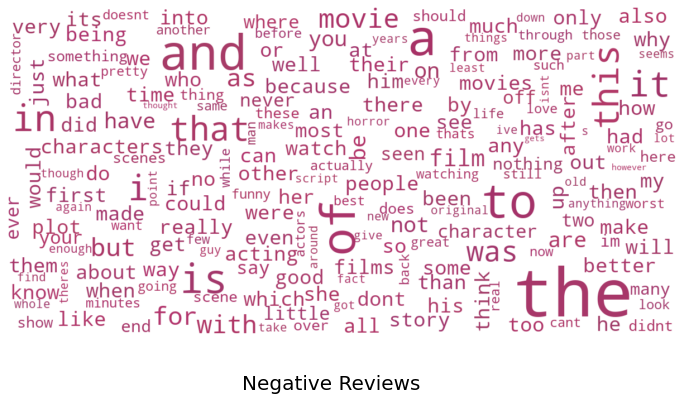

In [65]:
from wordcloud import WordCloud

def ri(a,b):
    return np.random.randint(a,b)

def green_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return f"rgb({ri(50,65)},{ri(180,220)},{ri(100,110)})"

def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return f"rgb({ri(160,180)},{ri(50,60)},{ri(100,110)})"

def make_wordcloud(frequencies, cf):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=56839
    ).generate_from_frequencies(frequencies)
    wordcloud.recolor(color_func = cf)
    return wordcloud

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
fig.suptitle("Negative Reviews", fontsize=20)
fig.subplots_adjust(top=2.3)
wordcloud = make_wordcloud(model.cond_param_freqs[0], red_color_func)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

wordcloud.to_file("plots/wc_neg.png")